# Modelo de Scoring para Riesgo de Crédito Corporativo (Empresas)

Esta aplicación implementa un modelo de scoring de crédito para clientes corporativos (empresas) utilizando el modelo Z-score (Altman Z-Score). ESte modelo incluye variables como: Working capital/Total assets, Retained earnings/Total assets, EBIT/Total assets, Market value of equity / Book value of total liabilities, Sales/Total assets.

El algoritmo completo incluye:

* Análisis Exploratorio de Datos (EDA): Examinaremos las características financieras clave de un conjunto de empresas.

* Modelo Z-Score: Explicaremos y aplicaremos este modelo, una fórmula multivariada que predice la probabilidad de que una empresa quiebre.

* Generación del Score y Segmentación: Calcularemos el Z-score para cada empresa y las clasificaremos en segmentos de riesgo (seguro y riesgoso).

* El análisis discriminante lineal (LDA): es una generalización del discriminante lineal de Fisher utilizado para encontrar una combinación lineal de características que se utilizan para separar dos o más clases o grupos.

* Pronóstico para Nuevas Empresas: Utilizaremos el modelo para evaluar el riesgo crediticio de nuevos clientes corporativos.

**Conceptos clave**:

* Análisis exploratorio de datos (EDA): es la fase inicial de investigación del proceso de análisis de datos en la que se examinan los datos mediante métodos estadísticos y visualizaciones para comprender sus principales características, descubrir patrones y relaciones, e identificar anomalías o problemas de calidad de los datos. El EDA ayuda a orientar la selección de modelos estadísticos adecuados y garantizar que los datos sean lo suficientemente sólidos como para su posterior análisis o aprendizaje automático.

* Probabilidad de incumplimiento (PD): probabilidad de que un prestatario no pague un préstamo.
* Scoring crediticio (scoring): número o puntuación que refleja tu historial y comportamiento financiero, indicando a los prestamistas la probabilidad de que pagues tus deudas.
* Modelo logit (o regresión logística): modelo estadístico que estima la probabilidad de un evento binario (con solo dos resultados posibles) usando una función logística para que la probabilidad esté acotada entre 0 y 1.

**Paso 1:** Configuración del Entorno de trabajo e importamos las librerías
---

Primero, instalamos las librerías necesarias. Usamos Kaggle para descargar el dataset y las demás para el análisis y modelado.

In [ ]:
# Instalación
!pip install --q kaggle

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

**Paso 2:** Carga de la Base de Datos
---

Para este modelo, utilizaremos un conjunto de datos públicos de Kaggle que contiene información financiera de empresas y un indicador de si la empresa quebró o no.

In [ ]:
# Conexión a Kaggle - Sube tu archivo kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cazapata25","key":"3bce823a88c986d15cf24fe16ae5457b"}'}

In [ ]:
# Config. de la conexión
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargamos y descomprimimos el dataset
!kaggle datasets download -d fedesoriano/company-bankruptcy-prediction
!unzip company-bankruptcy-prediction.zip

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction
License(s): copyright-authors
  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 449MB/s]
Archive:  company-bankruptcy-prediction.zip
  inflating: data.csv                


**Nota:** Para acceder a los datos de Kaggle, sigue estos pasos:

Ve a tu perfil de Kaggle, haz clic en tu avatar y selecciona "Settings". En la sección "API", haz clic en "Create New Token". Se descargará un archivo kaggle.json. Sube este archivo a tu entorno de Colab.



Ahora, cargamos el dataset en un DataFrame de pandas.

In [ ]:
datos = pd.read_csv('data.csv')
datos.head(3)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


In [ ]:
#datos.info()

**Paso 3:** Análisis Exploratorio de Datos (EDA) y Pre-procesamiento
---

El Análisis Exploratorio de Datos (EDA) es la fase inicial donde investigamos los datos para entender sus características, identificar patrones y anomalías.

Primero, renombraremos las columnas para que coincidan con las variables del modelo Z-score y facilitaremos su manejo.

In [ ]:
# Renombramos las columnas para mayor claridad
datos.rename(columns={
    'Bankrupt?': 'bankrupt',
    ' ROA(C) before interest and depreciation before interest': 'ROA_C',
    ' ROA(A) before interest and % after tax': 'ROA_A',
    ' ROA(B) before interest and depreciation after tax': 'ROA_B',
    ' Operating Gross Margin': 'operating_gross_margin',
    ' Realized Sales Gross Margin': 'realized_sales_gross_margin',
    ' Operating Profit Rate': 'operating_profit_rate',
    ' Pre-tax net Interest Rate': 'pre_tax_net_interest_rate',
    ' After-tax net Interest Rate': 'after_tax_net_interest_rate',
    ' Non-industry income and expenditure/revenue': 'non_industry_income_expenditure_revenue',
    ' Continuous interest rate (after tax)': 'continuous_interest_rate_after_tax',
    ' Operating Expense Rate': 'operating_expense_rate',
    ' Research and development expense rate': 'research_and_development_expense_rate',
    ' Cash flow rate': 'cash_flow_rate',
    ' Interest-bearing debt interest rate': 'interest_bearing_debt_interest_rate',
    ' Net Value Per Share (B)': 'net_value_per_share_B',
    ' Net Value Per Share (A)': 'net_value_per_share_A',
    ' Net Value Per Share (C)': 'net_value_per_share_C',
    ' Persistent EPS in the Last Four Seasons': 'persistent_eps_last_four_seasons',
    ' Cash Flow Per Share': 'cash_flow_per_share',
    ' Revenue Per Share (Yuan ¥)': 'revenue_per_share',
    ' Operating Profit Per Share (Yuan ¥)': 'operating_profit_per_share',
    ' Per Share Net profit before tax (Yuan ¥)': 'per_share_net_profit_before_tax',
    ' Realized Sales Gross Profit Growth Rate': 'realized_sales_gross_profit_growth_rate',
    ' Operating Profit Growth Rate': 'operating_profit_growth_rate',
    ' After-tax Net Profit Growth Rate': 'after_tax_net_profit_growth_rate',
    ' Regular Net Profit Growth Rate': 'regular_net_profit_growth_rate',
    ' Continuous Net Profit Growth Rate': 'continuous_net_profit_growth_rate',
    ' Total Asset Growth Rate': 'total_asset_growth_rate',
    ' Net Value Growth Rate': 'net_value_growth_rate',
    ' Total Asset Return Growth Rate Ratio': 'total_asset_return_growth_rate_ratio',
    ' Cash Reinvestment %': 'cash_reinvestment_percent',
    ' Current Ratio': 'current_ratio',
    ' Quick Ratio': 'quick_ratio',
    ' Interest Expense Ratio': 'interest_expense_ratio',
    ' Total debt/Total net worth': 'total_debt_total_net_worth',
    ' Debt ratio %': 'debt_ratio_percent',
    ' Net worth/Assets': 'net_worth_assets',
    ' Long-term fund suitability ratio (A)': 'long_term_fund_suitability_ratio_A',
    ' Borrowing dependency': 'borrowing_dependency',
    ' Contingent liabilities/Net worth': 'contingent_liabilities_net_worth',
    ' Operating profit/Paid-in capital': 'operating_profit_paid_in_capital',
    ' Net profit before tax/Paid-in capital': 'net_profit_before_tax_paid_in_capital',
    ' Inventory and accounts receivable/Net value': 'inventory_and_accounts_receivable_net_value',
    ' Total Asset Turnover': 'total_asset_turnover',
    ' Accounts Receivable Turnover': 'accounts_receivable_turnover',
    ' Average Collection Days': 'average_collection_days',
    ' Inventory Turnover Rate (times)': 'inventory_turnover_rate',
    ' Fixed Assets Turnover Frequency': 'fixed_assets_turnover_frequency',
    ' Net Worth Turnover Rate (times)': 'net_worth_turnover_rate',
    ' Revenue per person': 'revenue_per_person',
    ' Operating profit per person': 'operating_profit_per_person',
    ' Allocation rate per person': 'allocation_rate_per_person',
    ' Working Capital to Total Assets': 'working_capital_total_assets',
    ' Quick Assets/Total Assets': 'quick_assets_total_assets',
    ' Current Assets/Total Assets': 'current_assets_total_assets',
    ' Cash/Total Assets': 'cash_total_assets',
    ' Quick Assets/Current Liability': 'quick_assets_current_liability',
    ' Cash/Current Liability': 'cash_current_liability',
    ' Current Liability to Assets': 'current_liability_to_assets',
    ' Operating Funds to Liability': 'operating_funds_to_liability',
    ' Inventory/Working Capital': 'inventory_working_capital',
    ' Inventory/Current Liability': 'inventory_current_liability',
    ' Current Liabilities/Liability': 'current_liabilities_liability',
    ' Working Capital/Equity': 'working_capital_equity',
    ' Current Liabilities/Equity': 'current_liabilities_equity',
    ' Long-term Liability to Current Assets': 'long_term_liability_to_current_assets',
    ' Retained Earnings to Total Assets': 'retained_earnings_total_assets',
    ' Total income/Total expense': 'total_income_total_expense',
    ' Total expense/Assets': 'total_expense_assets',
    ' Current Asset Turnover Rate': 'current_asset_turnover_rate',
    ' Quick Asset Turnover Rate': 'quick_asset_turnover_rate',
    ' Working capitcal Turnover Rate': 'working_capital_turnover_rate',
    ' Cash Turnover Rate': 'cash_turnover_rate',
    ' Cash Flow to Sales': 'cash_flow_to_sales',
    ' Fixed Assets to Assets': 'fixed_assets_to_assets',
    ' Current Liability to Liability': 'current_liability_to_liability_2',
    ' Current Liability to Equity': 'current_liability_to_equity_2',
    ' Equity to Long-term Liability': 'equity_to_long_term_liability',
    ' Cash Flow to Total Assets': 'cash_flow_to_total_assets',
    ' Cash Flow to Liability': 'cash_flow_to_liability',
    ' CFO to Assets': 'cfo_to_assets',
    ' Cash Flow to Equity': 'cash_flow_to_equity',
    ' Current Liability to Current Assets': 'current_liability_to_current_assets',
    ' Liability-Assets Flag': 'liability_assets_flag',
    ' Net Income to Total Assets': 'net_income_to_total_assets',
    ' Total assets to GNP price': 'total_assets_to_gnp_price',
    ' No-credit Interval': 'no_credit_interval',
    ' Gross Profit to Sales': 'gross_profit_to_sales',
    ' Net Income to Stockholder\'s Equity': 'net_income_to_stockholders_equity',
    ' Liability to Equity': 'liability_to_equity',
    ' Degree of Financial Leverage (DFL)': 'degree_of_financial_leverage_dfl',
    ' Interest Coverage Ratio (Interest expense to EBIT)': 'interest_coverage_ratio',
    ' Net Income Flag': 'net_income_flag',
    ' Equity to Liability': 'equity_to_liability'
}, inplace=True)

Ahora, necesitamos crear las variables para el Z-score. Algunas de ellas ya existen en el dataset, pero otras deben ser calculadas. Por simplicidad, y dado que no tenemos el valor de mercado de lasempresas, usaremos el valor contable (Net Worth) como proxy.

In [ ]:
# Creación de las variables para el Z-Score de Altman
# X1: Working Capital / Total Assets (Ya existe como 'working_capital_total_assets')
# X2: Retained Earnings / Total Assets (Ya existe como 'retained_earnings_total_assets')
# X3: EBIT / Total Assets (ROA: EBIT/Total Assets)
datos['ebit_total_assets'] = datos['ROA_B']       # datos['net_income_to_total_assets']

# X4: Market Value of Equity / Book Value of Total Liabilities (Ya existe como: 'Equity to Liability'
# X5: Sales / Total Assets. Usaremos 'total_asset_turnover' que es una medida de eficiencia de los activos.
datos['sales_total_assets'] = datos['total_asset_turnover']

In [ ]:
# Seleccionamos las columnas relevantes
features_zscore = [
    'working_capital_total_assets',
    'retained_earnings_total_assets',
    'ebit_total_assets',
    'equity_to_liability',
    'sales_total_assets',
    'bankrupt'
]
datos_modelo = datos[features_zscore].copy()

# Reemplazamos ratios faltantes por cero (0) y/o manejamos valores infinitos que pueden surgir de la división
# por cero
datos_modelo = datos_modelo.fillna(0)
#datos_modelo.replace([np.inf, -np.inf], np.nan, inplace=True)
#datos_modelo.dropna(inplace=True)

In [ ]:
#datos_modelo.info()

In [ ]:
# EDA rápido y chequeos de calidad
#datos_modelo.describe()

In [ ]:
#datos_modelo['bankrupt'].value_counts()
#print(datos['bankrupt'].value_counts(normalize=True))

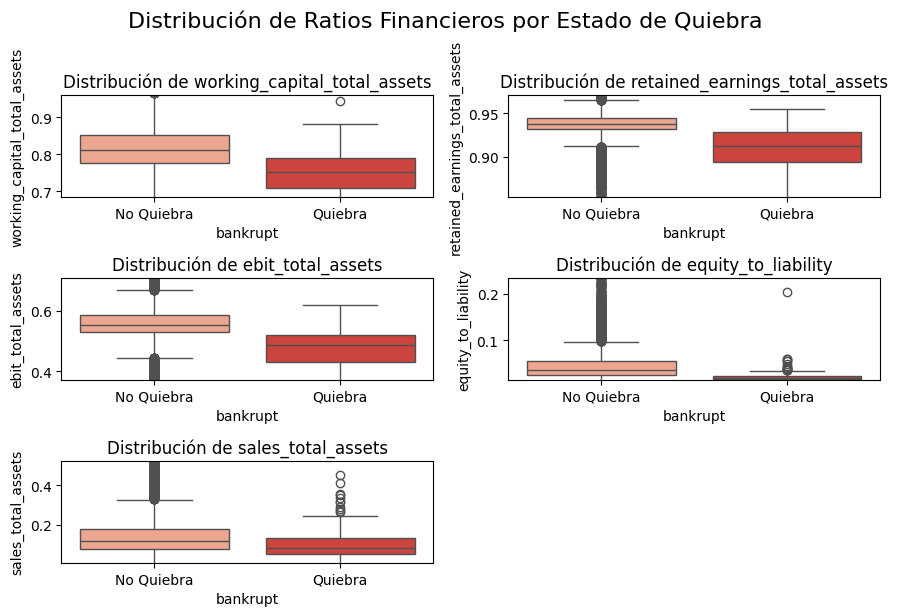

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(9, 6))
fig.suptitle('Distribución de Ratios Financieros por Estado de Quiebra', fontsize=16, y=1.02)

for i, col in enumerate(features_zscore):
    ax = axes[i//2, i%2]
    sns.boxplot(x='bankrupt', y=col, data=datos_modelo, ax=ax, palette="Reds")
    ax.set_title(f'Distribución de {col}')
    ax.set_xticklabels(['No Quiebra', 'Quiebra'])
    ax.set_ylim(datos_modelo[col].quantile(0.01), datos_modelo[col].quantile(0.99)) # Acotamos para mejor visualización

axes[2, 1].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
print("Distribución del Target (1 = Quiebra):")
print(datos_modelo['bankrupt'].value_counts(normalize=True))

Distribución del Target (1 = Quiebra):
bankrupt
0    0.967737
1    0.032263
Name: proportion, dtype: float64


**Observaciones del EDA**: Se observa que las empresas que quiebran (clase 1) tienden a tener valores consistentemente más bajos en los ratios de liquidez (working_capital_total_assets y sales_total_assets), rentabilidad (retained_earnings_total_assets y ebit_total_assets) y apalancamiento (equity_to_liability), lo que confirma su relevancia como predictores.


**El dataset está altamente desbalanceado, lo que confirma la necesidad de técnicas como SMOTE para entrenar un modelo predictivo**.

**Paso 4:** Modelo Z-Score de Altman y Generación del Score
---

Desarrollado por Edward Altman en 1968 (utilizando una muestra de 66 empresas manufactureras), el Modelo Z-Score es una fórmula utilizada para predecir la probabilidad de que una empresa se declare en quiebra. Originalmente, se derivó mediante el Análisis Discriminante Múltiple (ADM), una técnica estadística que encuentra la combinación lineal de variables que mejor separa dos o más grupos (en este caso, empresas que se quebrarón (o liquidarón) y empresas que no se quebrarón). La fórmula del modelo Z-score de Altman utiliza una combinación ponderada de cinco ratios financieros clave.

$$ Z=1.2 X_1 + 1.4X_2 +3.3 X_3 + 0.6 X_4 + 1.0 X_5 $$

Donde:

* $X_1$ = Working Capital / Total Assets: Mide la liquidez de la empresa.
* $X_2$ = Retained Earnings / Total Assets: Mide la rentabilidad acumulada.
* $X_3$ = Earnings Before Interest and Taxes (EBIT) / Total Assets: Mide la eficiencia operativa.
* $X_4$ = Market Value of Equity / Book Value of Total Liabilities: Mide el apalancamiento financiero.
* $X_5$ = Sales / Total Assets: Mide la eficiencia en la generación de ventas con los activos.

El Z-score de Altman se derivó originalmente con una técnica llamada Análisis Discriminante Múltiple (MDA). El MDA, también conocido como Análisis Discriminante Lineal (LDA) para dos clases, es una técnica de clasificación. Su objetivo es encontrar una combinación lineal de las variables predictoras (en nuestro caso, los cinco ratios financieros) que maximice la separación entre dos o más grupos (empresas en quiebra vs. no quiebra).

El resultado de esta combinación es una única puntuación, llamada función discriminante o score discriminante. A partir de estos putajes (z-score) de Altman definio umbrales para segmentar a las empresas en tres categorías de riesgo:

* Riesgo Bajo (Zona Segura) ($Z > 2.99$): Empresas con baja probabilidad de quiebra.

* Riesgo Moderado (Zona Gris) ($1.81 < Z < 2.99$): Empresas con una probabilidad moderada de quiebra.

* Riesgo Alto (Zona de Alerta) ($Z < 1.81$): Empresas con alta probabilidad de quiebra.

**Selección de variables: Modelo de Altman**

Su proceso fue el siguiente:

* Lista Inicial de Ratios: Comenzó con un conjunto de 22 ratios financieros que consideró potencialmente útiles para predecir la quiebra. Estos ratios se clasificaban en cinco categorías estándar: liquidez, rentabilidad, apalancamiento, solvencia y actividad.

* Selección de Variables Significativas: Utilizando el método estadístico (MDA), evaluó cuál de estos 22 ratios tenía mayor poder para distinguir entre los dos grupos. El objetivo era encontrar la combinación de variables que maximizara la distancia estadística entre el grupo de empresas sanas y el de empresas en quiebra.

* Variables Finales (5)

In [ ]:
# Función para calcular el Z-Score
def calcular_z_score(row):
    z = (1.2 * row['working_capital_total_assets'] +
         1.4 * row['retained_earnings_total_assets'] +
         3.3 * row['ebit_total_assets'] +
         0.6 * row['equity_to_liability'] +
         0.99 * row['sales_total_assets'])
    return z

# Aplicamos la función para crear la columna 'z_score'
datos_modelo['z_score'] = datos_modelo.apply(calcular_z_score, axis=1)

print("Empresas con su Z-Score calculado:")
print(datos_modelo[['z_score', 'bankrupt']].head())
print(datos_modelo[['z_score', 'bankrupt']].tail())

Empresas con su Z-Score calculado:
    z_score  bankrupt
0  3.506787         1
1  3.986333         1
2  3.852568         1
3  3.754533         1
4  4.100112         1
       z_score  bankrupt
6814  4.190187         0
6815  4.112895         0
6816  4.226134         0
6817  4.277370         0
6818  4.318535         0


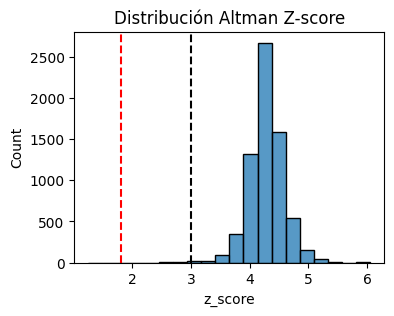

In [ ]:
# Visual: distribución Z
plt.figure(figsize=(4,3))
sns.histplot(datos_modelo['z_score'], bins=20)
plt.title("Distribución Altman Z-score")
plt.axvline(1.81, color='r', linestyle='--', label='Min')
plt.axvline(2.99, color='k', linestyle='--', label='Max');
plt.show();

**Paso 5:** Segmentación de Clientes por Riesgo
---

Se calcula el Z-score de cada empresa y luego las segmenta en zonas de riesgo según los umbrales.

In [ ]:
# Función para segmentar el riesgo basado en el Z-Score
def segmentar_riesgo(z_score):
    if z_score > 3:
        return '1. Riesgo Bajo'
    elif 1.81 <= z_score <= 2.99:
        return '2. Riesgo Moderado (Zona Gris)'
    else:
        return '3. Riesgo Alto'

datos_modelo['segmento_riesgo'] = datos_modelo['z_score'].apply(segmentar_riesgo)

# Análisis de la tasa de bancarrota por segmento
segment_analysis = datos_modelo.groupby('segmento_riesgo')['bankrupt'].agg(['count', 'mean']).rename(columns={'count': 'Num_Empresas', 'mean': 'Tasa_Bancarrota'})
                                                                      #  aggregation function to a Series, DataFrame, or GroupBy object
segment_analysis['Tasa_Bancarrota'] = (segment_analysis['Tasa_Bancarrota'] * 100).round(2)

print("Análisis de Tasa de Bancarrota por Segmento Z-Score:")
print(segment_analysis)

Análisis de Tasa de Bancarrota por Segmento Z-Score:
                                Num_Empresas  Tasa_Bancarrota
segmento_riesgo                                              
1. Riesgo Bajo                          6801             3.12
2. Riesgo Moderado (Zona Gris)            17            47.06
3. Riesgo Alto                             1             0.00


El análisis confirma la eficacia parcial del modelo: el segmento “Riesgo Alto” tiene una tasa de quiebra en comparación con la "Riesgo bajo".

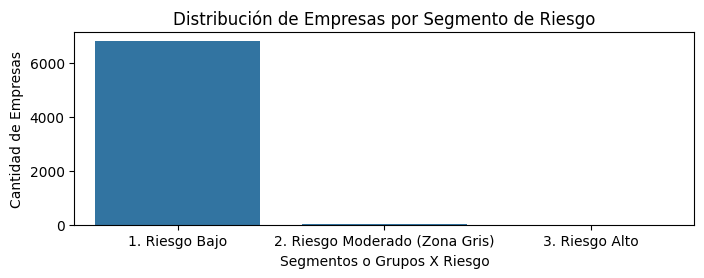

In [ ]:
plt.figure(figsize=(8, 2.5))
sns.barplot(x=segment_analysis.index, y=segment_analysis['Num_Empresas'].values)
plt.title('Distribución de Empresas por Segmento de Riesgo')
plt.xlabel('Segmentos o Grupos X Riesgo')
plt.ylabel('Cantidad de Empresas')
plt.show()

**Paso 6:** Pronóstico para Nuevos Clientes Corporativos
---
Ahora, podemos usar nuestro modelo para evaluar a nuevos solicitantes de crédito.

In [ ]:
# Creamos un DataFrame con datos de 3 nuevas empresas
nuevas_empresas = pd.DataFrame({
    'working_capital_total_assets': [0.4, 0.1, 0.2],
    'retained_earnings_total_assets': [0.5, 0.2, 0.3],
    'ebit_total_assets': [0.25, 0.05, 0.1],
    'equity_to_liability': [0.2, 0.8, 0.12],
    'sales_total_assets': [0.15, 0.9, 0.11]
})

print("Datos de nuevas empresas:")
print(nuevas_empresas)

Datos de nuevas empresas:
   working_capital_total_assets  retained_earnings_total_assets  \
0                           0.4                             0.5   
1                           0.1                             0.2   
2                           0.2                             0.3   

   ebit_total_assets  equity_to_liability  sales_total_assets  
0               0.25                 0.20                0.15  
1               0.05                 0.80                0.90  
2               0.10                 0.12                0.11  


In [ ]:
# Calculamos el Z-Score y asignamos segmento de riesgo
nuevas_empresas['z_score'] = nuevas_empresas.apply(calcular_z_score, axis=1)
nuevas_empresas['segmento_riesgo'] = nuevas_empresas['z_score'].apply(segmentar_riesgo)

print("\nResultados del Scoring para Nuevas Empresas:")
nuevas_empresas


Resultados del Scoring para Nuevas Empresas:


,working_capital_total_assets,retained_earnings_total_assets,ebit_total_assets,equity_to_liability,sales_total_assets,z_score,segmento_riesgo
0,0.4,0.5,0.25,0.20,0.15,2.2735,2. Riesgo Moderado (Zona Gris)
1,0.1,0.2,0.05,0.80,0.90,1.9360,2. Riesgo Moderado (Zona Gris)
2,0.2,0.3,0.10,0.12,0.11,1.1709,3. Riesgo Alto


**Paso 7:** Mejora del Modelo con Regresión Logística
---

Aunque el Z-score de Altman es una herramienta poderosa, podemos construir un modelo más sofisticado usando Regresión Logística. Su principal ventaja es que su resultado es una probabilidad directamente interpretable como Probabilidad de Incumplimiento (PD) , con un rango entre 0 y 1. Funciona ajustando una función logística (o función sigmoidea) a los datos para modelar la probabilidad de un evento de "incumplimiento". La Regresión Logística es ahora el estándar en la industria para este tipo de problemas por varias razones:

* Es más robusta si las variables no siguen una distribución normal.
* Su resultado puede interpretarse directamente como una Probabilidad de Incumplimiento (PD).
* Calcula un coeficiente (o peso) para cada variable.

El modelo logit (o regresión logística) es un modelo estadístico que estima la probabilidad de un evento binario (en este caso, quiebra o no quiebra) utilizando una función logística.

In [ ]:
# Definimos las variables independientes (X) y la dependiente (y)
X = datos_modelo.drop(['bankrupt', 'z_score', 'segmento_riesgo'], axis=1)
y = datos_modelo['bankrupt']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos el modelo de Regresión Logística
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

# Evaluamos el modelo
y_pred_proba = logit_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Área Bajo la Curva ROC (AUC): {auc:.4f}")

Área Bajo la Curva ROC (AUC): 0.9207


In [ ]:
# Predicciones y métricas
y_pred_base = logit_model.predict(X_test)
print(" Modelo Logístico Base (Sin SMOTE)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_base, target_names=['No Quiebra', 'Quiebra']))

--- Modelo Logístico Base (Sin SMOTE) ---
Accuracy: 0.9663

Reporte de Clasificación:
              precision    recall  f1-score   support

  No Quiebra       0.97      1.00      0.98      1320
     Quiebra       0.00      0.00      0.00        44

    accuracy                           0.97      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.94      0.97      0.95      1364



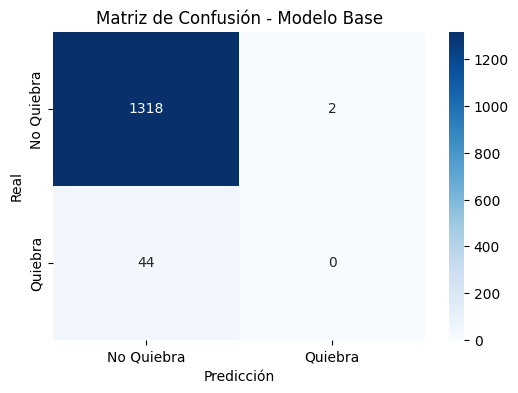

In [ ]:
# Matriz de Confusión
cm_base = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=['No Quiebra', 'Quiebra'], yticklabels=['No Quiebra', 'Quiebra'])
plt.title('Matriz de Confusión - Modelo Base')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.show()

In [ ]:
# Pronóstico de PD para las nuevas empresas
pd_nuevas = logit_model.predict_proba(nuevas_empresas[X.columns])[:, 1]
nuevas_empresas['pd_estimada_logit'] = pd_nuevas

print("\nResultados del Scoring Logit para Nuevas Empresas:")
print(nuevas_empresas)


Resultados del Scoring Logit para Nuevas Empresas:
   working_capital_total_assets  retained_earnings_total_assets  \
0                           0.4                             0.5   
1                           0.1                             0.2   
2                           0.2                             0.3   

   ebit_total_assets  equity_to_liability  sales_total_assets  z_score  \
0               0.25                 0.20                0.15   2.2735   
1               0.05                 0.80                0.90   1.9360   
2               0.10                 0.12                0.11   1.1709   

                  segmento_riesgo  pd_estimada_logit  
0  2. Riesgo Moderado (Zona Gris)           0.748272  
1  2. Riesgo Moderado (Zona Gris)           0.876923  
2                  3. Riesgo Alto           0.978895  


Modelo Mejorado: Regresión Logística con SMOTE
---

Como se identifica en el EDA, el modelo se entrena con un conjunto de datos donde los casos de quiebra son poco frecuentes. El modelo de regresión logística inicial presenta un rendimiento deficiente, ya que no identifica ninguna de las empresas en quiebra en el conjunto de prueba (recuperación de 0).

Para superar este problema, se utiliza la Técnica de Sobremuestreo Sintético de Minorías (SMOTE). SMOTE equilibra los datos de entrenamiento creando muestras sintéticas de la clase minoritaria (empresas en quiebra) en lugar de simplemente duplicar los existentes. Esto se logra mediante:

* Identificación de un punto de datos de clase minoritaria.

* Encontrar sus vecinos más cercanos en el espacio de características.

* Creación de un nuevo punto de datos sintético a lo largo de la línea que conecta el punto original y uno de sus vecinos.

Esto proporciona al modelo más ejemplos para comprender las características de las empresas en quiebra, lo que mejora significativamente su capacidad para detectarlas. La evaluación muestra una mejora drástica: el modelo con SMOTE identifica correctamente el 80 % de las empresas en quiebra del conjunto de prueba (recall = 0,80), mientras que el modelo base no identificó ninguna.

Aplicamos SMOTE al conjunto de entrenamiento para crear un dataset balanceado, permitiendo que el modelo aprenda a identificar mejor los casos de quiebra.

**Manejo de desbalance: SMOTE (oversampling de entrenamiento)**

Qué hace: aplica SMOTE sobre el conjunto de entrenamiento (no sobre test) para balancear clases.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Distribución del target antes de SMOTE:", y_train.value_counts().to_dict())
print("Distribución del target después de SMOTE:", pd.Series(y_train_res).value_counts().to_dict())

# Entrenar el nuevo modelo con datos balanceados
logit_smote = LogisticRegression()
logit_smote.fit(X_train_res, y_train_res)

# Predicciones y evaluación en el conjunto de prueba original
y_pred_smote = logit_smote.predict(X_test)
proba_smote = logit_smote.predict_proba(X_test)[:, 1]

print("\n Modelo Logístico Mejorado (Con SMOTE)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, proba_smote):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_smote, target_names=['No Quiebra', 'Quiebra']))

Distribución del target antes de SMOTE: {0: 4619, 1: 154}
Distribución del target después de SMOTE: {0: 4619, 1: 4619}

 Modelo Logístico Mejorado (Con SMOTE)
Accuracy: 0.8446
ROC AUC: 0.9136

Reporte de Clasificación:
              precision    recall  f1-score   support

  No Quiebra       0.99      0.85      0.91      1980
     Quiebra       0.15      0.79      0.25        66

    accuracy                           0.84      2046
   macro avg       0.57      0.82      0.58      2046
weighted avg       0.96      0.84      0.89      2046



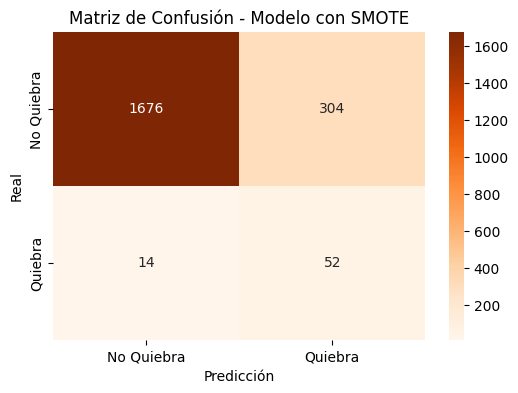

In [ ]:
# Matriz de Confusión
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Oranges', xticklabels=['No Quiebra', 'Quiebra'], yticklabels=['No Quiebra', 'Quiebra'])
plt.title('Matriz de Confusión - Modelo con SMOTE')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.show()

**Teoría / precaución:** SMOTE sintetiza ejemplos de la clase minoritaria; usar solo en entrenamiento para evitar fuga de información. Alternativas: re-weighting, undersampling, métodos ensemble para desbalance.

**Curva ROC Comparativa**

La curva ROC confirma que el modelo con SMOTE, a pesar de tener un accuracy menor, tiene una capacidad predictiva general ligeramente superior (mayor AUC) y es mucho más útil para el problema de negocio

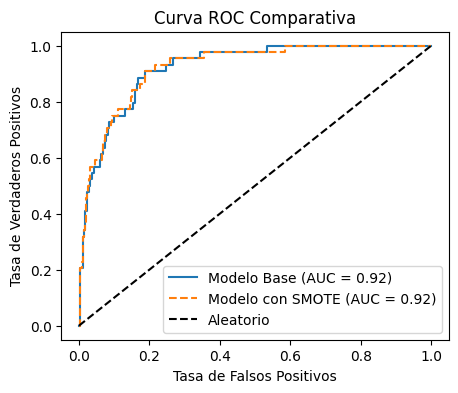

In [ ]:
# Curvas ROC para ambos modelos
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba)
fpr_smote, tpr_smote, _ = roc_curve(y_test, proba_smote)

plt.figure(figsize=(5, 4))
plt.plot(fpr_base, tpr_base, label=f'Modelo Base (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot(fpr_smote, tpr_smote, label=f'Modelo con SMOTE (AUC = {roc_auc_score(y_test, proba_smote):.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Comparativa')
plt.legend()
plt.show()